In [1]:
import gym
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from math import sqrt

from itertools import count
from collections import namedtuple

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Buffer of Transition 

In [2]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, *args):
        if len(self.memory) == self.capacity:
            self.memory.pop()
        
        self.memory.insert(0, Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) # a list of element from self.memory
    
    def __len__(self):
        return len(self.memory)

# Critic - Q Function

## Low-level information - Critic

In [3]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        '''
        2 Hidden layers
        400 & 300 units each
        action is only introduced in 2nd hidden layer
        '''
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400 + action_dim, 300)
        self.l3 = nn.Linear(300, 1)
        
        # weight init
        nn.init.uniform_(self.l1.weight, a=-1./sqrt(state_dim), b=1./sqrt(state_dim))
        nn.init.uniform_(self.l2.weight, a=-1./sqrt(400 + action_dim), b=1./sqrt(400 + action_dim))
        nn.init.uniform_(self.l3.weight, a=-3*1e-3, b=3*1e-3)
        # bias init
        nn.init.uniform_(self.l1.bias, a=-1./sqrt(state_dim), b=1./sqrt(state_dim))
        nn.init.uniform_(self.l2.bias, a=-1./sqrt(400 + action_dim), b=1./sqrt(400 + action_dim))
        nn.init.uniform_(self.l3.bias, a=-3*1e-3, b=3*1e-3)

        
    def forward(self, state, action):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(torch.cat([x, action], dim=1)))
        x = self.l3(x)
        return x

## Pixels - Critic

In [35]:
class PixelCritic(nn.Module):
    def __init__(self, state_dim, action_dim, H_in, W_in):
        super(PixelCritic, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv_size_out(size_in, stride=2, kernel_size=5, padding=0):
            return (size_in + 2 * padding - (kernel_size - 1) - 1) // stride + 1
        
        conv_H_out = conv_size_out(conv_size_out(conv_size_out(H_in, stride=1)))
        conv_W_out = conv_size_out(conv_size_out(conv_size_out(W_in, stride=1)))
         
        linear_input_size = conv_H_out * conv_W_out * 32 + action_dim
        self.fcn1 = nn.Linear(linear_input_size, 200)  # action is included here
        self.fcn2 = nn.Linear(200, 1)
        
        # weight init
        fan_in = 32 * 5 * 5  # num_filters * filter_h * filer_w
        nn.init.uniform_(self.conv1.weight, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.conv2.weight, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.conv3.weight, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.fcn1.weight, a=-1./sqrt(linear_input_size), b=1./sqrt(linear_input_size))
        nn.init.uniform_(self.fcn2.weight, a=-3*1e-4, b=3*1e-4)
        #bias init
        nn.init.uniform_(self.conv1.bias, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.conv2.bias, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.conv3.bias, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.fcn1.bias, a=-1./sqrt(linear_input_size), b=1./sqrt(linear_input_size))
        nn.init.uniform_(self.fcn2.bias, a=-3*1e-4, b=3*1e-4)
    
    def forward(self, screen, action):
        x = F.relu(self.bn1(self.conv1(screen)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        fcn_x = F.relu(self.fcn1(torch.cat([x.reshape((x.size(0), -1)), action], dim=1)))
        out = self.fcn2(fcn_x)
        return out

# Actor - Policy

## Low-level Actor

In [4]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, sup_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.sup_action = sup_action  # suppermum of action space
        
        # weight init
        nn.init.uniform_(self.l1.weight, a=-1./sqrt(state_dim), b=1./sqrt(state_dim))
        nn.init.uniform_(self.l2.weight, a=-1./sqrt(400), b=1./sqrt(400))
        nn.init.uniform_(self.l3.weight, a=-3*1e-3, b=3*1e-3)
        # bias init
        nn.init.uniform_(self.l1.bias, a=-1./sqrt(state_dim), b=1./sqrt(state_dim))
        nn.init.uniform_(self.l2.bias, a=-1./sqrt(400), b=1./sqrt(400))
        nn.init.uniform_(self.l3.bias, a=-3*1e-3, b=3*1e-3)
    
    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        x = self.sup_action * torch.tanh(self.l3(x))
        return x

## Pixels Actor

In [36]:
class PixelActor(nn.Module):
    def __init__(self, state_dim, action_dim, sup_action, H_in, W_in):
        super(PixelActor, self).__init__()
        self.sup_action = sup_action
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv_size_out(size_in, stride=2, kernel_size=5, padding=0):
            return (size_in + 2 * padding - (kernel_size - 1) - 1) // stride + 1
        
        conv_H_out = conv_size_out(conv_size_out(conv_size_out(H_in, stride=1)))
        conv_W_out = conv_size_out(conv_size_out(conv_size_out(W_in, stride=1)))
         
        linear_input_size = conv_H_out * conv_W_out * 32
        self.fcn1 = nn.Linear(linear_input_size, 200)  
        self.fcn2 = nn.Linear(200, 1)
        
        # weight init
        fan_in = 32 * 5 * 5  # num_filters * filter_h * filer_w
        nn.init.uniform_(self.conv1.weight, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.conv2.weight, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.conv3.weight, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.fcn1.weight, a=-1./sqrt(linear_input_size), b=1./sqrt(linear_input_size))
        nn.init.uniform_(self.fcn2.weight, a=-3*1e-4, b=3*1e-4)
        #bias init
        nn.init.uniform_(self.conv1.bias, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.conv2.bias, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.conv3.bias, a=-1./sqrt(fan_in), b = 1./sqrt(fan_in))
        nn.init.uniform_(self.fcn1.bias, a=-1./sqrt(linear_input_size), b=1./sqrt(linear_input_size))
        nn.init.uniform_(self.fcn2.bias, a=-3*1e-4, b=3*1e-4)
    
    def forward(self, screen):
        x = F.relu(self.bn1(self.conv1(screen)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        fcn_x = F.relu(self.fcn1(x.reshape((x.size(0), -1))))
        out = torch.tanh(self.fcn2(fcn_x)) * self.sup_action
        return out

# DDPG (mainly everything)

In [22]:
class DDPG(object):
    def __init__(self, state_dim, action_dim, sup_action, memory_capacity, batch_size, 
                 gamma=0.99, critic_lr=1e-3, actor_lr=1e-4, polyak=0.999):
        # critic
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr, weight_decay=1e-2)
        
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # actor
        self.actor = Actor(state_dim, action_dim, sup_action).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        self.actor_target = Actor(state_dim, action_dim, sup_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        
        # replay buffer
        self.replay_buffer = ReplayBuffer(memory_capacity)
        # hyper parameters
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.polyak = polyak
    
    def train(self, iteration):
        avg_critic_loss = 0
        avg_actor_loss = 0
        for i in range(iteration):
            # sample exp from replay buffer
            transitions = self.replay_buffer.sample(self.BATCH_SIZE)
            batch = Transition(*zip(*transitions))
            # pull out index (i.e. mask) in the batch & next_state of transitions having next_state is not None
            mask_nonFinal_next_states = torch.tensor(tuple(map(lambda s: s is not None, 
                                                              batch.next_state)), device=device, dtype=torch.uint8)
            nonFinal_next_states = torch.cat([s for s in batch.next_state
                                                 if s is not None])
            # construct tensor of state, action, reward
            states_batch = torch.cat(batch.state)
            actions_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # compute TD target
            next_state_act_val = torch.zeros([self.BATCH_SIZE, 1], device=device)
    #         print(self.actor_target(nonFinal_next_states))
    #         print("nonFinal_next_states:\n", nonFinal_next_states)
    #         print("critic output:\n",self.critic_target(nonFinal_next_states, 
    #                                                                         self.actor_target(nonFinal_next_states)))
    #         print("mask_nonFinal_next_states:\n", mask_nonFinal_next_states)
            next_state_act_val[mask_nonFinal_next_states] = self.critic_target(nonFinal_next_states, 
                                                                            self.actor_target(nonFinal_next_states))
            td_target = reward_batch + self.GAMMA * next_state_act_val.detach()

            critic_loss = F.mse_loss(self.critic(states_batch, actions_batch), td_target)  # MS of td_error
            avg_critic_loss += critic_loss.item()
            
            # call optimizer of critic to minimize loss
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            # Update actor
            actor_loss = -self.critic(states_batch, self.actor(states_batch)).mean() 
            avg_actor_loss += actor_loss.item()
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update target actor & target critic
            with torch.no_grad():
                for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                    target_param.data.copy_((1 - self.polyak) * param.data + self.polyak * target_param.data)

                for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                    target_param.data.copy_((1 - self.polyak) * param.data + self.polyak * target_param.data)
            
            return avg_critic_loss/iteration, avg_actor_loss/iteration
    
    def select_action(self, state):
#         state = torch.FloatTensor(state.reshape(1, -1)).to(device)
#         return self.actor(state).cpu().data.numpy().flatten()
        return self.actor(state)


# Utilities

In [23]:
def to_tensor(np_array):
    '''
    convert 1d np array to tensor (written as a row vector)
    '''
    return torch.FloatTensor(np_array.reshape(1, -1)).to(device)

def checkout_actor(render=False):
    state = env.reset()
    state = to_tensor(state)
    accu_reward = 0
    for step in count():
        action = agent.actor(state).detach()
        
        _act = action.cpu()
        next_state, reward, done, _ = env.step(_act.data.numpy().flatten())
        accu_reward += reward
        next_state = to_tensor(next_state)
        
        if render:
            env.render()
        if done:
            print("Episode %d [ACTOR] Finish after %d step\tAccumulated reward:%.3f" % (i_episode, step+1, accu_reward))
            print("-------------------------------------")
            break
        # Move on 
        state.data.copy_(next_state.data)
    return accu_reward

# checkout_actor()
# time.sleep(1)
# env.close()

# Training

In [24]:
env = gym.make("LunarLanderContinuous-v2")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
sup_action = torch.Tensor(env.action_space.high).to(device)

memory_capacity = int(1e6)
batch_size = 64

agent = DDPG(state_dim, action_dim, sup_action, memory_capacity, batch_size)

actor_accumulated_reward = []

In [25]:
max_episode = 1001
max_random_action_steps = 3000
random_action_steps = 0

flag_collecting_exp = True

act_noise = 0.075

for i_episode in range(max_episode):
    state = env.reset()
    state = to_tensor(state)
    for step in count():
        # Choose action
        if random_action_steps < max_random_action_steps:
            action = to_tensor(env.action_space.sample())
            random_action_steps += 1
        else:
            action = agent.select_action(state)    
        
        # take action & observe next state & reward
        _act = action.cpu().data.numpy().flatten()
        _act = np.random.normal(_act, act_noise).clip(env.action_space.low, env.action_space.high)
                                                                                             
        next_state, reward, done, _ = env.step(_act)
        next_state = to_tensor(next_state)
        reward = to_tensor(np.array([reward]))
        
        # update replay buffer
        action = to_tensor(_act)
        agent.replay_buffer.push(state, action, next_state, reward)
        
        # check if replay_buffer is enough for update
        if not flag_collecting_exp:
            avg_critic_loss, avg_actor_loss = agent.train(iteration=15)
        else:
            if agent.replay_buffer.__len__() > max_random_action_steps:
                flag_collecting_exp = False  # stop collecting experinences
                print("Finish collecting experience after %d episode" % i_episode)
        
        if done:
#             _rew = reward.cpu()
#             if not flag_collecting_exp:
#                 print("Episode %d finish with reward = %.2f" % (i_episode, _rew.data.numpy().flatten()))
#                 print("------------------------------------------------")
            break
        
        # move on
        state.data.copy_(next_state.data)
    
    if i_episode % 50 == 0 and not flag_collecting_exp:
        actor_accumulated_reward.append(checkout_actor())
        

Finish collecting experience after 20 episode
Episode 50 [ACTOR] Finish after 67 step	Accumulated reward:-543.406
-------------------------------------
Episode 100 [ACTOR] Finish after 74 step	Accumulated reward:-579.475
-------------------------------------
Episode 150 [ACTOR] Finish after 55 step	Accumulated reward:-455.201
-------------------------------------
Episode 200 [ACTOR] Finish after 75 step	Accumulated reward:-802.874
-------------------------------------
Episode 250 [ACTOR] Finish after 159 step	Accumulated reward:-348.324
-------------------------------------
Episode 300 [ACTOR] Finish after 122 step	Accumulated reward:-250.182
-------------------------------------
Episode 350 [ACTOR] Finish after 110 step	Accumulated reward:-312.520
-------------------------------------
Episode 400 [ACTOR] Finish after 87 step	Accumulated reward:-348.852
-------------------------------------
Episode 450 [ACTOR] Finish after 84 step	Accumulated reward:-424.743
---------------------------

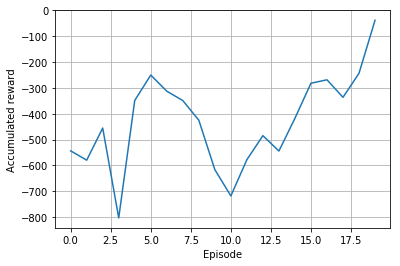

In [26]:
plt.figure(1)
plt.plot(actor_accumulated_reward)
plt.ylabel("Accumulated reward")
plt.xlabel("Episode")
plt.grid()
plt.show()

In [32]:
checkout_actor(True)

time.sleep(1)
env.close()

Episode 1000 [ACTOR] Finish after 101 step	Accumulated reward:2.492
-------------------------------------


In [23]:
# torch.save(agent.actor.state_dict(), 'lunarlander_ddpg_actor.pth')
# torch.save(agent.critic.state_dict(), 'lunarlander_ddpg_critic.pth')